<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

1.10.2+cu113
True
Num GPUs Available:  1


In [1]:
# it works well in python 3.8, gensim 4.1 (for word2vec), and tensorflow 2.8 (for Elmo)
import gensim
import sys
print(sys.version)
print(gensim.__version__)

import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
4.1.2
2.8.0
Num GPUs Available:  1


# Imports

In [2]:
import pandas as pd
import numpy as np
import operator
import matplotlib.patches as mpatches
import seaborn as sns


from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot


# Helper Functions

In [3]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [4]:
# Companies description
desc_df = pd.read_csv('stocks_data//constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('stocks_data//all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


In [5]:
desc_df.shape, stocks_df.shape

((505, 3), (619040, 7))

# Preprocess

In [6]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all its stocks
dates_dictionary = {date:{} for date in dates}

In [7]:
# just take a look companies_sector in list
list(companies_sector.items())[:4]

[('MMM', 'Industrials'),
 ('AOS', 'Industrials'),
 ('ABT', 'Health Care'),
 ('ABBV', 'Health Care')]

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [8]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

In [9]:
len(dates_dictionary['2013-02-08'])

476

# Train Word Embeddings

# Classifiers
We utilized classifiers to predict a stock's sector based on its daily price change to determine the quality of the Word2Vec embedding and optimal number of dimensions. After testing 4 classifiers for up to 30 dimensions, we found that the accuracy of our classifiers begins to plateau at 4 dimensions.

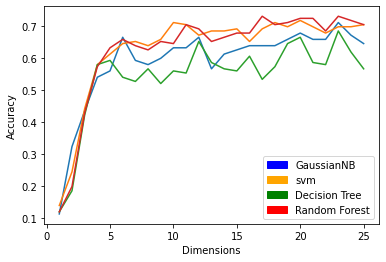

In [10]:
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
counter = []
classifier1_array = []
classifier2_array = []
classifier3_array = []
classifier4_array = []

# test accuracy at various number of dimensions
for j in range(1,26):
    model = Word2Vec(min_count=1, vector_size=j, negative=10, window=10)
    model.build_vocab(stocks_w2v_data)
    model.wv.load_word2vec_format('stocks_data/GoogleNews-vectors-negative300.bin', binary=True)
    model.train(stocks_w2v_data, total_examples=len(stocks_w2v_data), epochs=model.epochs)
    words = list(model.wv.key_to_index.keys())
    
    # X = model[model.wv.vocab] aims to get all vectors. now we can use model.wv.vectors instead
    X = model.wv.vectors 
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    # split data for cross validation
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    # predict sectors using GaussianNB, SVM, DecisionTreeClassifier and RandomForestClassifier
    model1 = GaussianNB()
    model1.fit(X_train, Y_train)
    preds1 = model1.predict(X_test)
    
    model2 = svm.SVC()
    model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    model3 = tree.DecisionTreeClassifier()
    model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)
    
    model4 = RandomForestClassifier()
    model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    classifier1_array.append(accuracy_score(Y_test, preds1))
    classifier2_array.append(accuracy_score(Y_test, preds2))
    classifier3_array.append(accuracy_score(Y_test, preds3))
    classifier4_array.append(accuracy_score(Y_test, preds4))
    
    counter.append(j)

np.set_printoptions(threshold=sys.maxsize)

pyplot.plot(counter,classifier1_array)
pyplot.plot(counter,classifier2_array)
pyplot.plot(counter,classifier3_array)
pyplot.plot(counter,classifier4_array)
pyplot.ylabel('Accuracy')
pyplot.xlabel('Dimensions')
gnb_patch=mpatches.Patch(color='blue', label='GaussianNB')
svm_patch=mpatches.Patch(color='orange', label='svm')
dtc_patch=mpatches.Patch(color='green', label='Decision Tree')
rfc_patch=mpatches.Patch(color='red', label='Random Forest')
pyplot.legend(handles=[gnb_patch,svm_patch, dtc_patch, rfc_patch], loc='best')
pyplot.show()